**Loading dataset**

In [1]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


file_id = '14S5hG4KbecPTx94IFu8MvPGQc13bB4ov'
destination = '/content/dataset.zip'
download_file_from_google_drive(file_id, destination)

In [2]:

import cv2
import zipfile
import numpy as np

faces = {}
with zipfile.ZipFile("dataset.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)

to see the dataset, please unzip 

In [94]:
#counting total images in the dataset
len(faces.values())

400

In [ ]:
#first image of the dataset
print(list(faces.values())[0])

In [4]:
#shape of the image in rows , col
(list(faces.values())[399]).shape

(112, 92)

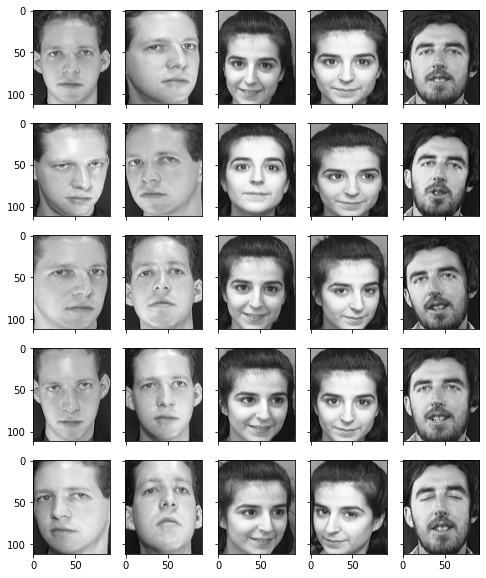

In [5]:
#plotting first 25 images out of 400 from the dataset
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5,5,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[:25] # take first 25 images
for i in range(25):
    axes[i%5][i//5].imshow(faceimages[i], cmap="gray")
plt.show()

In [30]:
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

Face image shape: (112, 92)


In [7]:
height, width = faceshape

In [9]:
#datails on folder and file structure and count
classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of pictures:", len(faces))

Number of classes: 40
Number of pictures: 400


In [61]:
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 1 of every class 1-39 as out-of-sample test
import re
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if re.search(r's*/1.pgm', key):
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key)
 
# Create facematrix as (n_samples,n_pixels) matrix i.e 1 * N^2 vector
facematrix = np.array(facematrix)

In [28]:
(facematrix).shape


(351, 10304)

We have considered total 351 images for training and remaining 49 for testing. Testing sample includes 1st image of each class 1-39 and all the ten image of class 40.


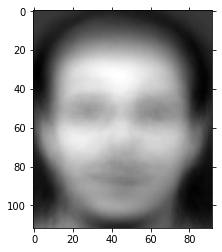

In [31]:
#calculate the average of all these face vectors  and plotted
mean_face = np.zeros((1,height*width))

for i in facematrix:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,351).flatten()

plt.imshow(mean_face.reshape(faceshape), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

In [32]:
#subtracting average face from all the face vectors
normalised_training_tensor = np.ndarray(shape=(351, height*width))

for i in range(351):
    normalised_training_tensor[i] = np.subtract(facematrix[i],mean_face)

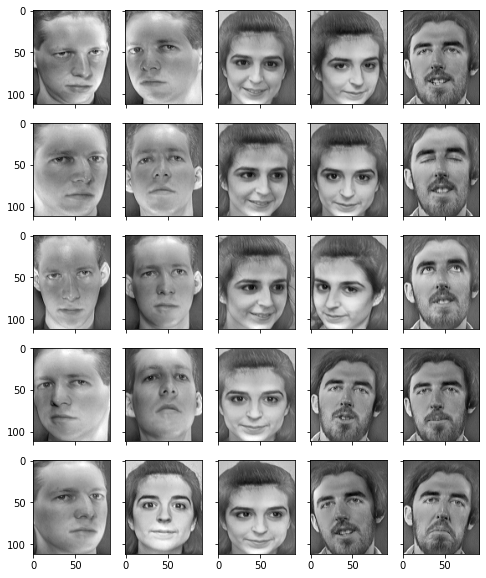

In [33]:
#plotting 1st 25 normalized face
fig, axes = plt.subplots(5,5,sharex=True,sharey=True,figsize=(8,10))
for i in range(25):
  axes[i%5][i//5].imshow(normalised_training_tensor[i].reshape(faceshape), cmap="gray")
plt.show()



In [34]:
#find Covariance matrix of each norm N as N * N.Transpose() but here we use numpy to calculate cov.
cov_matrix=np.cov(normalised_training_tensor)

print('Covariance Matrix Shape:', cov_matrix.shape)
print(cov_matrix)

Covariance Matrix Shape: (351, 351)
[[1507.44376844  338.94496445  416.99713776 ... -502.9809723
  -303.07147163 -267.82896079]
 [ 338.94496445 1368.91268567  385.25766509 ... -325.65400953
  -411.08451905 -373.5829347 ]
 [ 416.99713776  385.25766509 1540.14297223 ... -468.75989772
  -340.28839399 -430.25258634]
 ...
 [-502.9809723  -325.65400953 -468.75989772 ... 1213.77726328
   582.24439927  480.25926663]
 [-303.07147163 -411.08451905 -340.28839399 ...  582.24439927
  1010.01270425  654.89966331]
 [-267.82896079 -373.5829347  -430.25258634 ...  480.25926663
   654.89966331 1165.09461887]]


In [35]:
#calculating Eigenvalues and eigen vectors
eigenvalues, eigenvectors, = np.linalg.eig(cov_matrix)
print('eigenvalues.shape: {} eigenvectors.shape: {}'.format(eigenvalues.shape, eigenvectors.shape))

eigenvalues.shape: (351,) eigenvectors.shape: (351, 351)


In [36]:
eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the eigen pairs in descending order:
eig_pairs.sort(reverse=True)
eigval  = [eig_pairs[index][0] for index in range(len(eigenvalues))]
eigvec = [eig_pairs[index][1] for index in range(len(eigenvalues))]

sorted_ind = sorted(range(eigenvalues.shape[0]), key=lambda k: eigenvalues[k], reverse=True)

eigval = eigenvalues[sorted_ind]
eigvec = eigenvectors[sorted_ind]
train_set_files_sort = np.array(facematrix)[sorted_ind]

Cumulative proportion of variance explained vector: 
[0.17453924 0.26149588 0.33124482 0.39406945 0.43473622 0.46647822
 0.4933215  0.51842912 0.53930998 0.55703464 0.57291129 0.58661047
 0.59879668 0.60991933 0.62061529 0.63051223 0.63989149 0.64841621
 0.65664137 0.66444623 0.67204125 0.67921923 0.6861279  0.69237368
 0.69840333 0.70401488 0.70946353 0.71479431 0.72000829 0.72496377
 0.72968045 0.73430768 0.73871588 0.74304113 0.74719368 0.75124199
 0.75513911 0.75893451 0.76263078 0.76619584 0.76958143 0.7728737
 0.77610819 0.77927457 0.78238254 0.7853964  0.78832741 0.79119575
 0.79397196 0.79666877 0.79928535 0.80183284 0.80435312 0.8068577
 0.80928852 0.81163505 0.81394574 0.81622844 0.8184473  0.82065813
 0.82278527 0.82488135 0.82693656 0.82894306 0.83086567 0.83278374
 0.83464521 0.8364811  0.8383013  0.84008301 0.84185014 0.84355059
 0.84523984 0.84690825 0.84855997 0.85018952 0.85180576 0.85340172
 0.85497826 0.85652108 0.85802839 0.85950061 0.86095837 0.86237137
 0.86377997

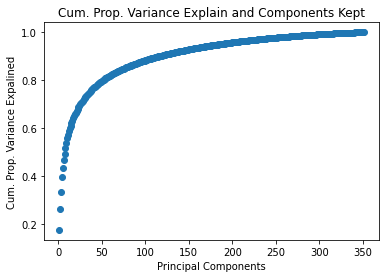

In [37]:
var_comp_sum = np.cumsum(eigval)/sum(eigval)

# Show cumulative proportion of varaince with respect to components
print("Cumulative proportion of variance explained vector: \n%s" %var_comp_sum)

# x-axis for number of principal components kept
num_comp = range(1,len(eigval)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

In [38]:
#transposing the vector for dot product
reduced_data = np.array(eigvec[:351]).transpose()
reduced_data.shape

(351, 351)

In [39]:
#verifying the shape for dot product
print(facematrix.transpose().shape, reduced_data.shape)

(10304, 351) (351, 351)


In [40]:
#represent each face vectors in the linear combination of the best K eigenvectors
proj_data = np.dot(facematrix.transpose(),reduced_data)
proj_data = proj_data.transpose()
proj_data.shape

(351, 10304)

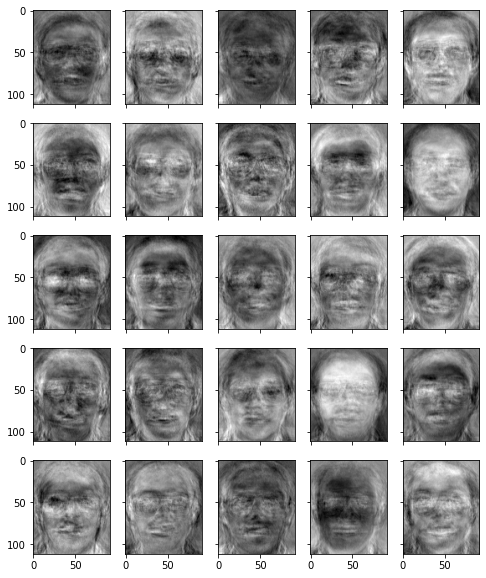

In [41]:
#plotting the faces thus obtained from above linear comn=bination
fig, axes = plt.subplots(5,5,sharex=True,sharey=True,figsize=(8,10))
for i in range(25):
  axes[i%5][i//5].imshow(proj_data[i].reshape(faceshape), cmap="gray")
plt.show()


In [42]:
# Generate weights as a KxN matrix where K is the number of eigenfaces and N the number of samples
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
print(w.shape)

(351, 351)


Photo match s19/2.pgm with Euclidean distance 23806860.858631
Photo match s27/5.pgm with Euclidean distance 34298122.759144
2 image matched within threshold
Best match s19/2.pgm with Euclidean distance 23806860.858631


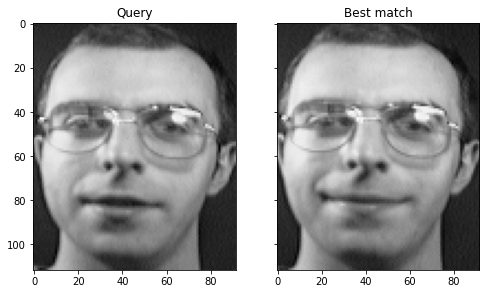

In [79]:
# Test on out-of-sample image of existing class( say for all "s*/1.pgm" where * --> 1 to 39)
query = faces["s19/1.pgm"]
query = np.array(query, dtype='float64').flatten()

normalised_uface_vector = np.subtract(query,mean_face)
w_unknown = np.dot(proj_data, normalised_uface_vector.transpose())


#counting no if matches with the query image
euclidean_distance = np.linalg.norm(w - w_unknown, axis=1)
threshold = 35000000.00   #decided after looking at distance for every other faces
count = 0
for i in range(351):
  #print (euclidean_distance[i])
  if (euclidean_distance[i]<=threshold):
    print("Photo match %s with Euclidean distance %f" % (facelabel[i], euclidean_distance[i]))
    count+=1
if count ==0:
  print("No image matched within threshold")
else:
  print(str(count)+" image matched within threshold")

best_match = np.argmin(euclidean_distance)

print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

No image matched within threshold
Best match s35/2.pgm with Euclidean distance 46574244.320301


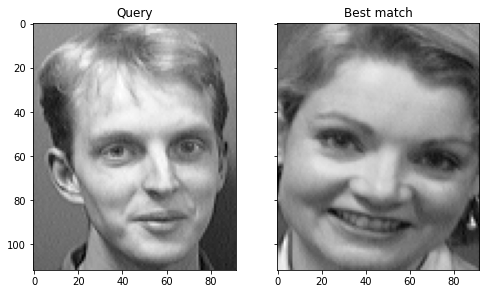

In [81]:
# Test on out-of-sample image of new class
query = faces["s40/1.pgm"]
query = np.array(query, dtype='float64').flatten()

normalised_uface_vector = np.subtract(query,mean_face)
w_unknown = np.dot(proj_data, normalised_uface_vector.transpose())

#counting no if matches with the query image
euclidean_distance = np.linalg.norm(w - w_unknown, axis=1)
threshold = 35000000.00   #decided after looking at distance for every other faces
count = 0
for i in range(351):
  #print (euclidean_distance[i])
  if (euclidean_distance[i]<=threshold):
    print("Photo match %s with Euclidean distance %f" % (facelabel[i], euclidean_distance[i]))
    count+=1
if count ==0:
  print("No image matched within threshold")
else:
  print(count+" image matched within threshold")

best_match = np.argmin(euclidean_distance)

print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

In [91]:
#Accuracy analysis for out of sample image of existing class
accurate = 0
for i in range(1,40):
  sample = "s"+str(i)+"/1.pgm"
  query = faces[sample]
  query = np.array(query, dtype='float64').flatten()

  normalised_uface_vector = np.subtract(query,mean_face)
  w_unknown = np.dot(proj_data, normalised_uface_vector.transpose())

  euclidean_distance = np.linalg.norm(w - w_unknown, axis=1)
  threshold = 35000000.00
  best_match = np.min(euclidean_distance)

  if(best_match <= threshold):
    accurate+=1

print( " accuracy is :"+ str(accurate*100/39)+ "%")


 accuracy is :82.05128205128206%


Accuracy of match for all the out of sample images which belong to existing class in training data is **82.05 %**

In [90]:
#Accuracy analysis for out of sample image of new class
accurate = 0
for i in range(1,11):
  sample = "s40/"+str(i)+".pgm"
  
  query = faces[sample]
  query = np.array(query, dtype='float64').flatten()

  normalised_uface_vector = np.subtract(query,mean_face)
  w_unknown = np.dot(proj_data, normalised_uface_vector.transpose())

  euclidean_distance = np.linalg.norm(w - w_unknown, axis=1)
  threshold = 35000000.00
  best_match = np.min(euclidean_distance)

  if(best_match > threshold):
    accurate+=1

print( " accuracy is :"+ str(accurate*100/10)+ "%")

 accuracy is :100.0%


Accuracy of match for all the out of sample images which belong to existing class in training data is **100 %** which implies that the algorithm correctly detects that the image of the person doesnot exist.